In [1]:
'''
Date: 10 Apr 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10 dataset

VGG16 model with one Flexible Layer in block1

Modified 03/01/2021
by Linnea Evanson
To find rerun for Flexible and Baseline and find averaged results. 
To save results and create figure.

'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

epsilons = [0, .05, .1, .15, .2, .25, .3]

# ======================================== prepare the dataset ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


Files already downloaded and verified
CUDA Available:  True


In [2]:
#Model
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
#         self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
#         cond = torch.sub(self.t_2(t), self.threshold1.cuda())
#         t_2_2 = self.m(cond*50)*self.t_2(t) # 
#         t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
#         t = torch.add(t_2_2, t_1_1)
        
        return self.t_1(t)

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )

    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [3]:
'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
the min_val = -2.117 and max_val = 2.64 and not {0,1}
'''

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
        #    continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        for i in range(0,len(final_pred)-1):
            if final_pred[i].sub(target[i]) == 0:
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [4]:
#---------------------------------MAIN LOOP TO FIND AVERAGE----------------------------------------------

# Loop to run for 10 iterations then find the average and standard error of the mean:
accuracies = np.zeros((10, len(epsilons)))  #save accuracy for all iterations, each epsilon

for i in range(10):
    print("-------Iteration:",i,"--------")
    # Initialize the network
    model = VGG16().to(device)

    # Load the pretrained model
    state = torch.load('../Imperial_Flexible_CNNs_Original/models/base_downsampled/VGG16-BASE-nnmodule_50xdownsampledmodel_150_20.pth')

    model.load_state_dict(state['model'])

    # Set the model in evaluation mode. In this case this is for the Dropout layers
    model.eval()

    # Evaluate model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

    print('Accuracy on the test dataset is: %f %%' % (100 * correct / total))

    # Run test for each epsilon
    for j, eps in enumerate(epsilons):
        print("j:", j,"   eps:", eps)
        acc, ex = test(model, device, testloader, eps)
        print("acc:", acc)
        accuracies[i,j] = acc


-------Iteration: 0 --------
Accuracy on the test dataset is: 20.120000 %
j: 0    eps: 0
Epsilon: 0	Test Accuracy = 1997 / 100 = 19.97
acc: 19.97
j: 1    eps: 0.05
Epsilon: 0.05	Test Accuracy = 1668 / 100 = 16.68
acc: 16.68
j: 2    eps: 0.1
Epsilon: 0.1	Test Accuracy = 1494 / 100 = 14.94
acc: 14.94
j: 3    eps: 0.15
Epsilon: 0.15	Test Accuracy = 1370 / 100 = 13.7
acc: 13.7
j: 4    eps: 0.2
Epsilon: 0.2	Test Accuracy = 1249 / 100 = 12.49
acc: 12.49
j: 5    eps: 0.25
Epsilon: 0.25	Test Accuracy = 1136 / 100 = 11.36
acc: 11.36
j: 6    eps: 0.3
Epsilon: 0.3	Test Accuracy = 1041 / 100 = 10.41
acc: 10.41
-------Iteration: 1 --------
Accuracy on the test dataset is: 20.120000 %
j: 0    eps: 0
Epsilon: 0	Test Accuracy = 1994 / 100 = 19.94
acc: 19.94
j: 1    eps: 0.05
Epsilon: 0.05	Test Accuracy = 1665 / 100 = 16.65
acc: 16.65
j: 2    eps: 0.1
Epsilon: 0.1	Test Accuracy = 1489 / 100 = 14.89
acc: 14.89
j: 3    eps: 0.15
Epsilon: 0.15	Test Accuracy = 1368 / 100 = 13.68
acc: 13.68
j: 4    eps: 0.2

In [5]:
#Save
np.save("FGSM_acc_10iterations_basedownsampled", accuracies)

In [6]:
#Calculate averages:
avg_acc = np.mean(accuracies, axis = 0)

#Calculate error:
sem = np.std(accuracies, axis = 0) / np.sqrt(10)   #standard error over 10 samples

#Save average values:
np.save("FGSM_acc_average_basedownsampled", avg_acc)
np.save("FGSM_acc_sem_basedownsampled", sem)


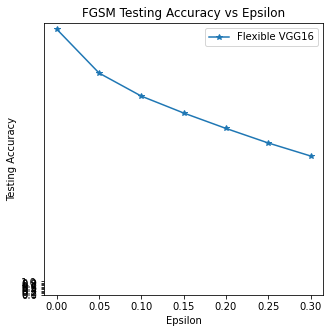

In [7]:
#Plot average:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(epsilons, avg_acc, "*-", label = "Flexible VGG16")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FGSM Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.savefig('./figures/fgsm_basedownsampled_average.png', format='png')
plt.show()


No handles with labels found to put in legend.


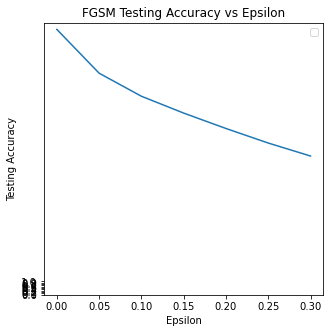

In [8]:
#Plot average with error bars:
plt.figure(figsize=(5,5))
plt.errorbar(epsilons, avg_acc, yerr= sem)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FGSM Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.savefig('./figures/fgsm_basedownsampled_average_sem.png', format='png')
plt.show()